In [1]:
import numpy as np
import pandas as pd
import time
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
import joblib
import json
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import matplotlib
import os

%load_ext autoreload
%autoreload 2
# %matplotlib notebook
%matplotlib inline

In [2]:
# body_part = "head"
# file_names = ['./training_data/head_data_1.log',
#              './training_data/head_data_2.log',
#              './training_data/head_data_3.log',
#              './training_data/head_data_4.log',
#              './training_data/head_data_5.log',
#              './training_data/head_data_6.log']

# body_part = "shoulder_right"
# file_names = [
#              './training_data_old/shoulder_right_data_1.log',
#              './training_data_old/shoulder_right_data_2.log',
#              './training_data_old/shoulder_right_data_3.log',
#              './training_data_old/shoulder_right_data_4.log',
#              './training_data_old/shoulder_right_data_5.log']

body_part = "shoulder_left"
file_names = ['./training_data/shoulder_left_train_5_6_7_9_10.log'
             ]
# file_names = ['./training_data/shoulder_left_train_2.log',
#               './training_data/shoulder_left_train_5_6_7_9_10.log'
#              ]
# file_names = ['./training_data/shoulder_left_5.log',
#               './training_data/shoulder_left_6.log',
#               './training_data/shoulder_left_7.log']

# body_part = "shoulder_left"
# file_names = ['./training_data/shoulder_left_1.log',
#               './training_data/shoulder_left_2.log',
#               './training_data/shoulder_left_3.log']

In [3]:
abnormal_threshold = 0.5
dataset = []

for name in file_names:
    df = pd.read_csv(name, delim_whitespace=True, header=0)
    
    # interpolate nan outputs (loss tracking)
#     for c in df.columns[-3:]:
#         df[c] = df[c].interpolate()
    
    # interpolate abnormal inputs
    for c in df.columns[:-3]:
        bad_idx = df.index[df[c].pct_change().abs().ge(abnormal_threshold)]
        df.loc[bad_idx, c] = np.nan
        df[c] = df[c].interpolate()
    
    dataset.append(df)
    
dataset_len = [len(data) for data in dataset]
dataset = pd.concat(dataset) 

print(f'{np.sum(dataset_len)} values')

dataset = dataset.values[1:len(dataset)-1,0:]
dataset = dataset[abs(dataset[:,12])!=0.0,:]
dataset = dataset[abs(dataset[:,13])!=0.0,:]
dataset = dataset[abs(dataset[:,14])!=0.0,:]

print(f'{len(dataset)} values after filtering outliers')

euler_set = dataset[:, 12:15]
sensors_set = dataset[:, :12]
print(f'max euler {str(np.amax(euler_set))}')
print(f'min euler {str(np.amin(euler_set))}')

250240 values
250238 values after filtering outliers
max euler nan
min euler nan


In [4]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from libs.orientation_utils import compute_rotation_matrix_from_euler, compute_ortho6d_from_rotation_matrix, compute_rotation_matrix_from_ortho6d, compute_euler_angles_from_rotation_matrices

In [5]:
euler_set_in = np.zeros_like(euler_set)
euler_set_in[:, 0] = euler_set[:, 2] 
euler_set_in[:, 1] = euler_set[:, 1] 
euler_set_in[:, 2] = euler_set[:, 0] 

euler_set = torch.Tensor(euler_set_in).cuda()
rot_set = compute_rotation_matrix_from_euler(euler_set)
rot_set = compute_ortho6d_from_rotation_matrix(rot_set).cpu().detach().numpy()

In [6]:
model_path = f"./outputs/{body_part}_lstm_rot6D"

sensors_scaler = joblib.load(f'{model_path}/scaler.pkl')

In [7]:
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.loggers.csv_logs import CSVLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from libs.data_modules import SensorsDataModule
from libs.nn_models import LSTMRegressor, mse_seq

In [8]:
model = LSTMRegressor.load_from_checkpoint(checkpoint_path=f"{model_path}/best.ckpt")

In [9]:
device = "cuda"
model.to(device)
torch.set_grad_enabled(False)
model.eval()

LSTMRegressor(
  (lstm): LSTM(12, 100, num_layers=2, batch_first=True, dropout=0.2)
  (linear): Linear(in_features=100, out_features=6, bias=True)
  (tanh): Tanh()
)

In [42]:
def plot_test(sensors_set, euler_set, look_back=5, save_name=None):

    # Specific testing for abnormalities
    
    if body_part == "shoulder_right":
        start_idx = 202261
        end_idx = 204681
    elif body_part == "shoulder_left":
        start_idx = 21500 # 4500
        end_idx = 22880 # 4850
#         start_idx = 25000
#         end_idx = 26000
#         ab_idx = 25411
    elif body_part == "head":
        start_idx = 900
        end_idx = 950

    test_idxs = slice(start_idx, end_idx)

    # Prepare inputs and do the prediction
    in_set = []
    for i in range(start_idx, end_idx):
        in_set.append(sensors_set[i:i+look_back] + np.random.normal(size=(look_back, 12))*0.0)

    in_set = torch.tensor(in_set, dtype=torch.float32).to(device)
    out_set = model(in_set)[:, -1]
    rot_pred = compute_rotation_matrix_from_ortho6d(out_set)

    euler_pred = compute_euler_angles_from_rotation_matrices(rot_pred)
    euler_gt = torch.tensor(euler_set[test_idxs], dtype=torch.float32).to(device)
    
    print(f"MSE: {mse_seq(euler_pred, euler_gt)}")
    
    euler_pred = euler_pred.cpu().detach().numpy()
    euler_gt = euler_gt.cpu().detach().numpy()

    # Plotting
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    ax.scatter(euler_gt[:, 0], euler_gt[:, 1], euler_gt[:, 2], c=np.arange(len(euler_gt)), alpha=0.1)
    sc = ax.plot(euler_pred[:,0], euler_pred[:,1], euler_pred[:,2])
    sc = ax.scatter(euler_pred[:,0], euler_pred[:,1], euler_pred[:,2], c=np.arange(len(euler_pred)), alpha=0.5)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    
#     ax.set_xlim([-2, 0.5])
#     ax.set_ylim([-1.5, 0.])
#     ax.set_zlim([-2, 0.])

    ax.set_xlim(-2.0,0.3)
    ax.set_ylim(-1.5,-0.5)
    ax.set_zlim(-2.5,0.5)
    
    plt.colorbar(sc)
    plt.show()
    
    if save_name:
        fig.savefig('./outputs/'+body_part+'_'+save_name+'.png', dpi=100, bbox_inches='tight')

In [43]:
test_dataset = pd.concat([pd.read_csv(f, delim_whitespace=True, header=0) for f in file_names])
test_dataset = test_dataset.values[1:len(test_dataset)-1,0:]
test_euler_set = dataset[:, 12:15]
test_sensors_set = test_dataset[:, :12]
test_transformed_sensors_set = sensors_scaler.transform(test_sensors_set)

MSE: 0.02878749743103981


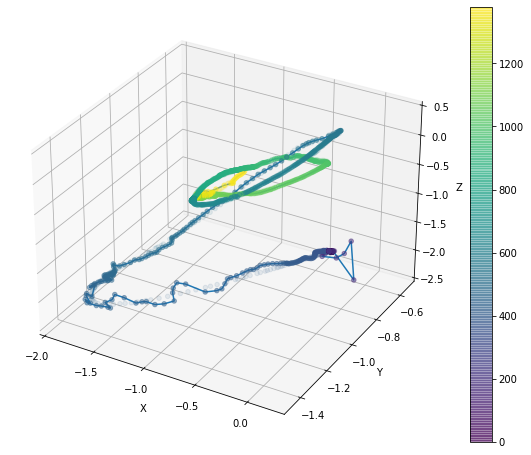

In [44]:
# Plot with raw inputs
plot_test(test_transformed_sensors_set, test_euler_set, look_back=10)

In [45]:
orig_euler_set = dataset[:, 12:15]
orig_sensors_set = dataset[:, :12]
orig_transformed_sensors_set = sensors_scaler.transform(orig_sensors_set)

MSE: 0.011163723655045033


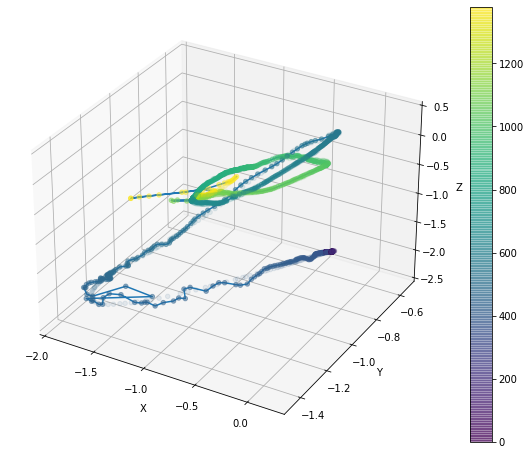

In [46]:
# Plot with interpolated inputs
plot_test(orig_transformed_sensors_set, orig_euler_set, save_name="lstm")

In [15]:
np.set_printoptions(precision=3, suppress=True)

In [16]:
abnormal_idx = np.where(np.abs(test_transformed_sensors_set - orig_transformed_sensors_set) > 0.5)

In [17]:
abnormal_idx

(array([  2278,   8328,   8329,   9959,   9959,  10960,  10960,  15375,
         15375,  15544,  15544,  15544,  16123,  16123,  19542,  19868,
         21682,  23251,  25457,  25457,  25457,  26125,  26125,  29842,
         36616,  36620,  41215,  49549,  50703,  50703,  51590,  52388,
         57088,  59633,  59633,  64732,  65976,  65976,  65976,  68177,
         68494,  68789,  68789,  73211,  73211,  77894,  79159,  79159,
         79159,  83586,  83587,  83588,  83601,  83773,  83773,  84069,
         84069,  84069,  85147,  85147,  86400,  86542,  86542,  89478,
         89849,  92735,  92735,  97028,  97971, 100264, 101054, 104778,
        106728, 108536, 108536, 111420, 118659, 118659, 119194, 124510,
        132957, 138295, 142947, 142947, 144332, 148015, 151560, 151560,
        157125, 157179, 157179, 166643, 166643, 166643, 168055, 168402,
        168402, 168402, 170345, 170345, 170345, 172357, 173491, 176310,
        176310, 181450, 181739, 181739, 183527, 183527, 183527, 

In [18]:
test_sensors_set[abnormal_idx]

array([ -10.14,  -11.31,   -2.47,   31.98,   99.58,   27.04,   13.26,
         40.43,  108.55,   -0.13,   -0.13,    0.13,   27.3 ,   -5.59,
         -1.95,    7.8 ,    0.13,  -72.15,  -40.3 ,   28.34,  110.11,
         44.07,   12.61,  -86.45,  -22.1 ,  -36.4 ,  110.5 ,    5.85,
       -108.55,   84.37,    6.24,   -0.13,   -0.13,   -0.13,    0.13,
        -17.16,   -2.73,   29.9 ,   17.81,  -21.06,    0.13,   -0.13,
          0.13,   98.93,  -67.73,  121.16, -109.33,  -59.93,   61.36,
          1.04,    3.64,    7.02,  120.9 ,   -0.13,    0.13,   19.76,
         61.49,    9.88,   -0.13,    0.13,   27.56,  -69.29,   85.02,
        -77.22,    0.13,  -49.92,   94.9 ,   -0.13,    0.13, -109.72,
         -0.13,    0.13,  119.86,   -8.06,   24.18,  -66.04,   -0.13,
          0.13,    0.13,   -0.13, -102.96,    4.16,   -0.13,    0.13,
         -3.12,   -0.13,   -0.13,   -0.13,    8.06,  -48.49,  -47.97,
         32.5 ,   36.79,   -2.86,   68.77,   -0.13,   -0.13,    0.13,
        -10.14,    1

In [19]:
orig_sensors_set[abnormal_idx]

array([  73.06 ,  -76.277,  -78.455,  -21.147,  -14.56 ,  -55.033,
         89.57 ,  -36.487,  -59.757,   64.74 ,  -74.36 ,   62.617,
        -65.173,  -51.437,   82.333,  121.507,   88.66 ,  -21.06 ,
         30.68 ,  -30.377,  -22.793,  -26.043,  113.317,   53.993,
        -72.898,   18.763,  -31.113,   88.79 ,   17.073,  -59.15 ,
        119.08 ,  102.267,   73.927,  -81.77 ,  -47.71 ,   70.85 ,
       -100.923,  -58.63 ,   77.653,   52.39 ,   94.207,   95.897,
         83.33 ,    0.078,   31.243,  -73.883,  -38.697,   31.807,
         12.74 ,   84.977,   95.388,  105.798,   31.937,  -85.627,
        -62.01 ,  -52.52 ,  -16.727,  113.36 ,  -51.22 ,   69.073,
        -34.71 ,   32.11 ,   14.777,   -4.593, -101.487,   44.59 ,
         -6.717,   86.017,   97.63 ,   -2.73 ,   88.703,  -46.887,
          5.33 , -107.293,  -65.173,   30.897, -118.17 ,   69.94 ,
         60.32 ,   96.807,    8.537,   88.487,  -76.917,  101.227,
         56.68 ,  -45.543,  -85.15 ,  -75.963,  -48.533,    8.